In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import simpy
from tqdm import tqdm # progress bar

## Inputs

In [2]:
# Import data file

file = r'hud-doe.xls'
df = pd.read_excel(file)  # read Inigo's file

# Set input data

cost_mirror_unit =           5 / 1000  # keuro/mm^2

price_vehicle =              35000 / 1000  # k€uro/vehicle

assembly_cost =              556.20 / 1000  # k€euro/vehicle

cost_vechicle_without_HUD =  20000 / 1000  # k€uro /vehicle

weight_vehicle_without_HUD = 1800  # kg /vehicle

cost_fuel =                  1.9 / 1000  # kEuro / liter

kilometers_year =            10000  # km/year

market_window =              10  # years

sales_distr =                [0.2, 0.4, 0.8, 1, 1, 1, 1, 1, 0.8, 0.4, 0.2]

theoretical_demand =         70000  # vehicles/year

operation_time =             10  # years

development_time =           0  # years

production_time =            0.1  # years

sales_time =                 0.1  # years

year =                       2035  # year

person_height =              180  # cm

# Initialize calculated variables

discrete_time =              0.01

discount_rate =              0.08

simulation_duration =        30  # years

time_between_counting =      1  # year

i =                          0  # for updating the sales distribution

## Surplus Value Model Class

In [3]:
class SV:

    def __init__(self, env):

        self.env = env

        self.i = i

        # initializing costs and revenues

        self.development_cost = 0
        self.production_cost = 0
        self.integration_cost = 0
        self.operation_cost = 0

        self.total_development_cost = 0
        self.total_production_cost = 0
        self.total_operation_cost = 0
        self.total_revenue = 0
        self.total_cost = 0

        self.cost = 0
        self.revenue = 0
        self.net_revenue = - self.cost
        self.NPV = self.net_revenue / (1 + discount_rate) ** env.now
        self.cumulativeNPV = self.NPV

        # initializing data for plot
        
        self.obs_time = [env.now]
        self.cashflow_level = [self.cumulativeNPV]

        # initializing counters for the different phases

        self.total_demand = 0
        self.in_development = 0
        self.in_production = 0
        self.in_sale = 0
        self.total_produced = 0
        self.in_operation = 0
        self.EoL = 0

        # start the business process every time an option is defined,
        # start the development,if development time != 0, start the
        # market delayed, else start instantaneously

        # self.action = start_delayed(env,
        #                             self.market(),
        #                             self.development_time)

        self.action = env.process(self.lifecycle())

        self.action = env.process(self.observe())

        self.action = env.process(self.calculate())

    def lifecycle(self):

        self.in_development = 1

        yield env.timeout(development_time)

        self.in_development = 0

        self.action = env.process(self.market())

    def market(self):

        while env.now < market_window:

            self.action = env.process(self.business_run())

            yield env.timeout(time_between_counting)

            self.i += 1

    def business_run(self):

        # set vehilce demand

        # calculation of current demand
        self.current = math.ceil(theoretical_demand
                                 * Prob_yes_1
                                 * sales_distr[self.i])

        # set vehicles in production

        self.in_production += self.current

        yield env.timeout(production_time)

        # after production_time, vehicles are in sale

        self.in_production -= self.current

        self.in_sale += self.current

        yield env.timeout(sales_time)

        # after sales time, set vehicles in use

        self.in_sale -= self.current

        self.in_operation += self.current

        yield env.timeout(operation_time)

        # after operation time, set vehicles out of life

        self.in_operation -= self.current

        self.EoL += self.current

    def observe(self):
        while True:

            self.obs_time.append(env.now)
            self.cashflow_level.append(self.cumulativeNPV)

            # print (self.revenue)

            # if self.cumulativeNPV < 0:
            #     self.payback_period = env.now

            yield env.timeout(discrete_time)

    # function for cost, revenue and NPV calculations

    def calculate(self):

        while True:
            # all calculations are scaled down by the discrete time

            # the total cost is "spread" along the production time
            self.production_cost = self.in_production \
                                   * cost_vehicle \
                                   * discrete_time

            self.revenue = self.in_sale * (price_vehicle) * discrete_time

            # self.operation_cost = self.in_operation \
            #                       * ((kilometers_year/fuel_consumpt) \
            #                       * cost_fuel) * discrete_time

            self.total_revenue += self.revenue

            # sum of cost and revenue and caluclation of NPV
            self.cost = self.production_cost  # + self.operation_cost
            self.total_cost -= self.cost
            self.net_revenue = self.revenue - self.cost
            self.NPV = self.net_revenue / (1 + discount_rate) ** env.now
            self.cumulativeNPV += self.NPV

            yield env.timeout(discrete_time)



## Calculations

In [4]:
# Initialize list for surplus value and lyfecycle costs

surplus_value = []

lifecycle_costs = []

# calculate engineering variables and run SV model for each option

points = 100

for j in tqdm(range(0, points)):

    #print("Step " + str(j+1) + " out of " + str(points), end="\r")
    # retrieve FoV

    a = df.at[j, 'FullHorizontalFOV']

    b = df.at[j, 'FullVerticalFOV']

    # calculate % FoV

    FoV = (a * b * 100) / (67 * 20)   # the maximum values are for

    # cost model

    cost_mirror = cost_mirror_unit * df.at[j, 'mirrorSize']

    cost_vehicle = cost_mirror \
        + cost_vechicle_without_HUD \
        + assembly_cost  # euro

    # weight model

    weight_hud = 0.1 * df.at[j, 'volume']  # kg

    weight_vehicle = weight_hud + weight_vehicle_without_HUD  # kg

    # fuel consumption model

    fuel_consumpt = weight_vehicle * math.exp(-4.7)  # km / liter

    fuel_cost_year = kilometers_year/fuel_consumpt * cost_fuel  # keuro/year

    # calculate demand, imported from demand.py

    Lin_no__1 = 400.389457364428 + -0.0496637629531165 \
        * (FoV) + 0.0438458326033747 \
        * (fuel_consumpt) + 3.53646955685314 \
        * (cost_fuel * 1000) + -0.0958055046356103 \
        * (person_height) + 0.0000987106990985412 \
        * (price_vehicle * 1000) + -0.193495221339535 \
        * (year)

    Prob_yes_1 = 1 / (1 + math.exp(Lin_no__1))  # demand

    # run Surplus Value of alternative

    # launch environemnt

    env = simpy.Environment()

    hud = SV(env)

    env.run(until=simulation_duration)

    surplus_value.append(hud.cumulativeNPV/1000)  # converted in million euro

    lifecycle_costs.append(-hud.total_cost/1000)

print("")
print("Finished calculations")

100%|██████████| 100/100 [00:01<00:00, 54.76it/s]


Finished calculations


## Plotting

Plot results


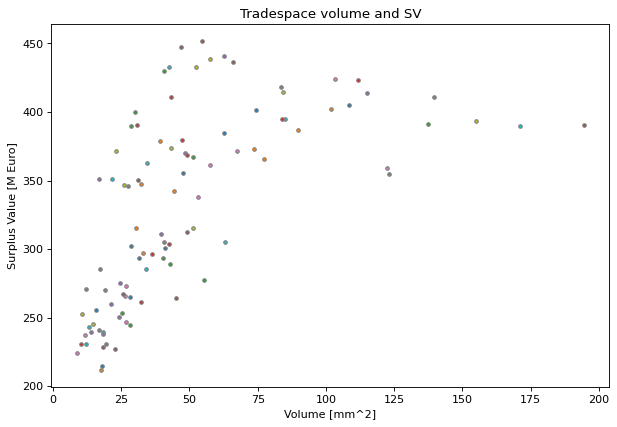

The end


"\n#plot surplus value curves\n\nplt.figure(figsize=(9, 6), dpi=80, facecolor='w', edgecolor='k')\n\n\nplt.plot(hud.obs_time, hud.cashflow_level, 'g', label= 'hud')\n\n\n#plt.plot(A2.obs_time, A2.cashflow_level, 'b', label= Alternatives.A1.name)\n\n\nplt.axhline(linewidth=0.5, color='k')\nplt.xlim(0, 30)\nplt.title('System Impact Assessment')\nplt.xlabel('Simulation Time (years)')\nplt.ylabel('Surplus Value (kEuro)')\nplt.legend(loc='upper left')\nplt.show()\n\n"

<Figure size 432x288 with 0 Axes>

In [5]:
# make tradespace plot between volume and SV
print("Plot results")
plt.figure(num=None, figsize=(9, 6), dpi=80)

for i in range(0, points):

    plt.scatter(df.at[i, 'volume'],
                surplus_value[i],
                label=None,
                s=10,
                linewidths=1,
                edgecolors='gray')

plt.title('Tradespace volume and SV')
plt.xlabel('Volume [mm^2]')
plt.ylabel('Surplus Value [M Euro]')
# plt.legend(bbox_to_anchor=(0.7, 0.9), loc='upper center', borderaxespad=0.)

plt.show()
plt.savefig("temp.png")

print("The end")


'''

df['Surplus Value [Meuro]'] = surplus_value

df['Lifecycle costs [Meuro]'] = lifecycle_costs

'''


'''
#plot surplus value curves

plt.figure(figsize=(9, 6), dpi=80, facecolor='w', edgecolor='k')


plt.plot(hud.obs_time, hud.cashflow_level, 'g', label= 'hud')


#plt.plot(A2.obs_time, A2.cashflow_level, 'b', label= Alternatives.A1.name)


plt.axhline(linewidth=0.5, color='k')
plt.xlim(0, 30)
plt.title('System Impact Assessment')
plt.xlabel('Simulation Time (years)')
plt.ylabel('Surplus Value (kEuro)')
plt.legend(loc='upper left')
plt.show()

'''
